<a href="https://colab.research.google.com/github/ZPavlo/ML_projects/blob/master/TrafficSigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/lab2/'

# https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed

import os
import torch
import pandas as pd
import numpy as np
import cv2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
torch.cuda.is_available()

True

# Data preprocessing 

У цій секції проводиться попередня обробка датасету та його розширення

In [0]:
label_names = pd.read_csv(os.path.join(root_path, "label_names.csv"))
label_names = list(label_names["SignName"])
len(label_names)

43

In [0]:
import pickle

def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features'].astype(np.float32)
        # 1D numpy.ndarray type, for train = (34799,)   
        target = d['labels']                       
        # 2D numpy.ndarray type, for train = (34799, 2) 
        sizes = d['sizes']                         
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']                        
       
    return input_data, target, sizes, coords

x_train, y_train, _, _ = load_data(os.path.join(root_path, 'train.pickle'))
x_valid, y_valid, _, _ = load_data(os.path.join(root_path, 'valid.pickle'))


Як можна помітити на гістограмі нижче, кількість елементів класів у датасеті не є однаковою. Потрібно це виправити. Для цього застосуємо функцію аугментації, яка доповнює датасет даними, на які накладені зміни у вигляді повороту чи зміни відтінку.

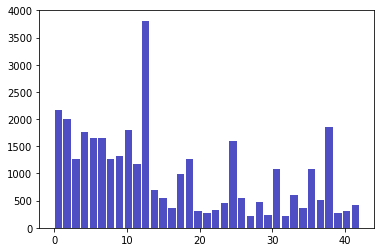

In [0]:
import matplotlib.pyplot as plt

number_of_element_in_classes = np.bincount(y_train)
plt.hist(y_train, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

In [0]:
from tqdm import tqdm

def rotation_changing(image):
    # Defining angle range
    angle_range = 25
    # Defining angle rotation
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    # Getting shape of image
    rows, columns, channels = image.shape
    # Implementing rotation
    # Calculating Affine Matrix
    affine_matrix = cv2.getRotationMatrix2D((columns / 2, rows / 2),
                                            angle_rotation, 1)
    # Warping original image with Affine Matrix
    rotated_image = cv2.warpAffine(image, affine_matrix, (columns, rows))
    # Returning rotated image
    return rotated_image

def brightness_changing(image):
    # Converting firstly image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Defining random value for changing brightness
    random_brightness = 0.25 + np.random.uniform()
    # Implementing changing of Value channel of HSV image
    image_hsv[:, :, 2] = image_hsv[:, :, 2] * random_brightness
    # Converting HSV changed image to RGB
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    # Returning image with changed brightness
    return image_rgb

# Defining function for transformation: brightness + rotation
def transformation_brightness_rotation(image):
    return brightness_changing(rotation_changing(image))


# Defining function for getting random image of one label
def random_image(x_train, y_train, y_number):
    # Getting indexes of needed 'y_number' from 'y_train'
    # Defining True - False array
    image_indexes = np.where(y_train == y_number)
    # Getting random index of needed label
    # 'np.bincount(y_train)' - array with number of examples for every label
    # 'np.bincount(y_train)[y_number] - 1' - number of examples for 'y_number' label
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    # Returning random image from 'x_train'
    # 'x_train[image_indexes]' - returns array with only 'y_number' label
    # 'x_train[image_indexes][random_index]' - random image of needed label
    return x_train[image_indexes][random_index]


# Defining function for equalization training dataset
def equalize_training_dataset(x_train, y_train):
    # Getting number of examples for every label
    number_of_examples_for_every_label = np.bincount(y_train)
    # Calculating total amount of unique labels
    number_of_labels = np.arange(len(number_of_examples_for_every_label))

    # Iterating over all number of labels
    # Showing progress ber with 'tqdm'
    for i in tqdm(number_of_labels):
        # Calculating how many examples is needed to add for current label
        # 'np.mean(number_of_examples_for_every_label)' - average number over examples for every label
        number_of_examples_to_add = int(
            np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]

        # Defining temporary arrays for collecting new images
        x_temp = []
        y_temp = []

        # Getting random image from current label
        # Transforming it and adding to the temporary arrays
        for j in range(number_of_examples_to_add):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(
                transformation_brightness_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train

save_data = os.path.join(root_path, "data.pickle")

if not os.path.isfile(save_data):
    print("Save")
    x_train, y_train = equalize_training_dataset(x_train, y_train)
    d = {"data": x_train,
         "label": y_train}
    with open(save_data, 'wb') as f:
      pickle.dump(d, f)
else:
    print("Load")
    with open(save_data, 'rb') as f:
      d = pickle.load(f, encoding='latin1')

      x_train = d["data"]
      y_train = d["label"]

Load


Проведемо нормалізацію даних:

In [0]:
std = np.array([0.229, 0.224, 0.225]).astype(np.float32)
mean = np.array([0.485, 0.456, 0.406]).astype(np.float32)

def transpose_and_normalization(data):
    data = data / 255.0
    data = (data - mean) / std
    return data.transpose(0, 3, 1, 2)

x_train = transpose_and_normalization(x_train)
x_valid = transpose_and_normalization(x_valid)

Для кращого навчання потрібно перемішати елементи датасету:

In [0]:
shuffle = np.arange(len(x_train))
np.random.shuffle(shuffle)

x_train = x_train[shuffle]
y_train = y_train[shuffle]

In [0]:
x_train.shape

(86989, 3, 32, 32)

Як можна помітити тепер, кількість елементів кожного класу в датасеті однакова.

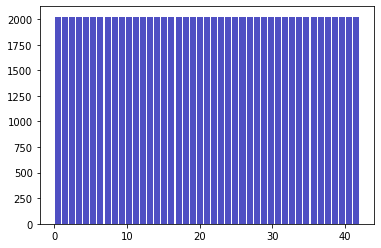

In [0]:
import matplotlib.pyplot as plt

number_of_element_in_classes = np.bincount(y_train)
plt.hist(y_train, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

Для кращого розуміння візуалізуємо перших 81 елементів.

(81, 32, 32, 3)


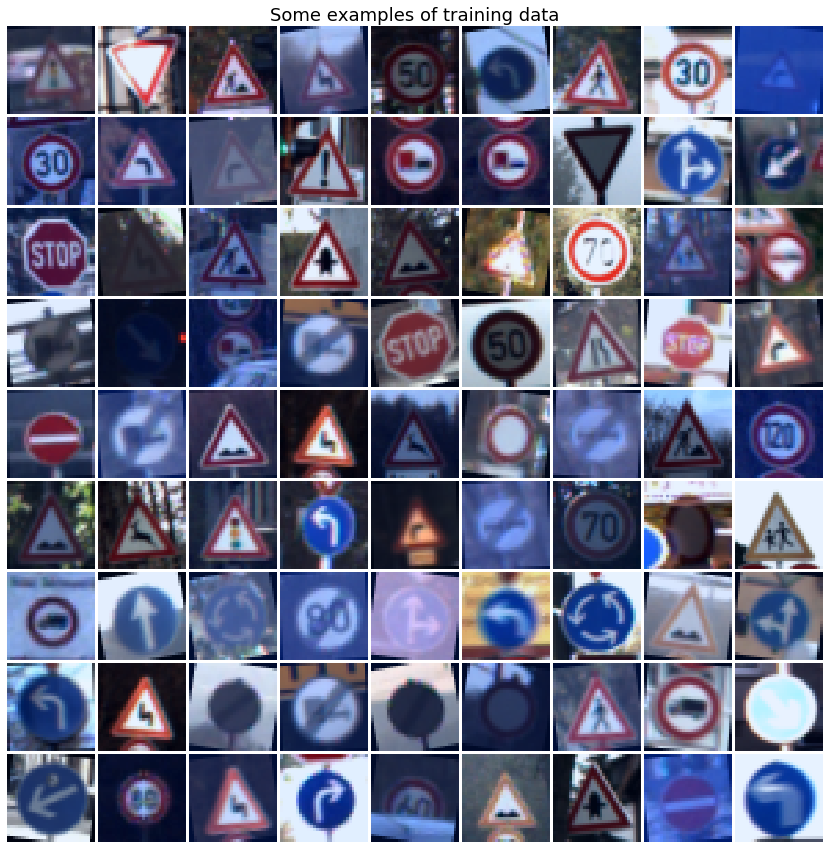

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import math

def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid

examples = x_train[:81, :, :, :].transpose(0, 2, 3, 1)
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

# Проектування моделі

У цій секції ми ініціалізуємо модель та всі необхідні модулі для її навчання. Було проведено експерименти та визначено, що саме при розмірі ядра 5 нейронна мережа показує кращий результат.



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# model = nn.Sequential(nn.Conv2d(3, 32, 7, padding=1), 
#                       nn.ReLU(), 
#                       nn.MaxPool2d(2, 2),
#                       nn.Flatten(),
#                       nn.Linear(6272, 512),
#                       nn.ReLU(), 
#                       nn.Linear(512, 43))

model = nn.Sequential(nn.Conv2d(3, 32, 5, padding=1), 
                      nn.ReLU(), 
                      nn.MaxPool2d(2, 2),
                      nn.Flatten(),
                      nn.Linear(7200, 256),
                      nn.ReLU(), 
                      nn.Linear(256, 43))

# model = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), 
#                       nn.ReLU(), 
#                       nn.MaxPool2d(2, 2),
#                       nn.Flatten(),
#                       nn.Linear(8192, 512),
#                       nn.ReLU(), 
#                       nn.Linear(512, 43))

7200
if torch.cuda.is_available():
  model.cuda()
  print("Cuda True")
else:
  print("No Cuda")

Cuda True


Для тренування використаємо SGD з моментумом, а також MultiStepLR для автоматичного зменшення learning rate

In [0]:
EPOCH_SIZE = 20
BATCH_SIZE = 128
TRAIN_SIZE = len(x_train)
VALID_SIZE = len(x_valid)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.8)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [6, 12], gamma=0.4)

checkpoint_path = os.path.join("gdrive/My Drive/saves/net")
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

checkpoint_path = os.path.join(checkpoint_path, '{epoch}-{type}.pth')

# Тренування моделі

In [0]:
def train(ep, model):

    model.train()
    global_loss = 0.0
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):

        optimizer.zero_grad()
 
        inputs = torch.from_numpy(x_train[i: i + BATCH_SIZE])
        labels = torch.from_numpy(y_train[i: i + BATCH_SIZE]).long()

        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

        inputs.requires_grad = True

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        global_loss += float(loss)

        if ((i + 1) // BATCH_SIZE) % 100 == 0:
          print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
              loss.item(),
              optimizer.param_groups[0]['lr'],
              epoch=ep,
              total_samples=TRAIN_SIZE,
              trained_samples=i
          ))

    return global_loss / (i+1)

def eval_training(ep, model):
    model.eval()

    test_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for i in range(0, VALID_SIZE, BATCH_SIZE):

            inputs = x_valid[i: i + BATCH_SIZE]
            labels = y_valid[i: i + BATCH_SIZE]
            
            inputs = torch.from_numpy(inputs)#.permute(0, 3, 1, 2)
            labels = torch.from_numpy(labels).long()

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum()

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        BATCH_SIZE * test_loss / (i+1),
        correct.float() / VALID_SIZE
    ))
    print()

    return float(correct) / VALID_SIZE

best_acc = 0.0
acc_list = []
loss_list = []


for epoch in range(1, EPOCH_SIZE):

    train_loss = train(epoch, model)
    acc = eval_training(epoch, model)
    
    train_scheduler.step(epoch)

    loss_list.append(train_loss)
    acc_list.append(acc)

    if best_acc < acc:
        torch.save(model.state_dict(), checkpoint_path.format(epoch=epoch, type='best'))
        best_acc = acc
        continue

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), checkpoint_path.format(epoch=epoch, type='regular'))

print('Finished Training')

Training Epoch: 1 [0/86989]	Loss: 3.7720	LR: 0.050000
Training Epoch: 1 [12800/86989]	Loss: 0.9874	LR: 0.050000
Training Epoch: 1 [25600/86989]	Loss: 0.7426	LR: 0.050000
Training Epoch: 1 [38400/86989]	Loss: 0.3594	LR: 0.050000
Training Epoch: 1 [51200/86989]	Loss: 0.1741	LR: 0.050000
Training Epoch: 1 [64000/86989]	Loss: 0.4788	LR: 0.050000
Training Epoch: 1 [76800/86989]	Loss: 0.1522	LR: 0.050000
Test set: Average loss: 0.7600, Accuracy: 0.8506

Training Epoch: 2 [0/86989]	Loss: 0.2924	LR: 0.050000
Training Epoch: 2 [12800/86989]	Loss: 0.2803	LR: 0.050000
Training Epoch: 2 [25600/86989]	Loss: 0.3469	LR: 0.050000
Training Epoch: 2 [38400/86989]	Loss: 0.1076	LR: 0.050000
Training Epoch: 2 [51200/86989]	Loss: 0.1614	LR: 0.050000
Training Epoch: 2 [64000/86989]	Loss: 0.4198	LR: 0.050000
Training Epoch: 2 [76800/86989]	Loss: 0.2790	LR: 0.050000
Test set: Average loss: 0.8967, Accuracy: 0.8635

Training Epoch: 3 [0/86989]	Loss: 0.0888	LR: 0.050000
Training Epoch: 3 [12800/86989]	Loss: 0.17

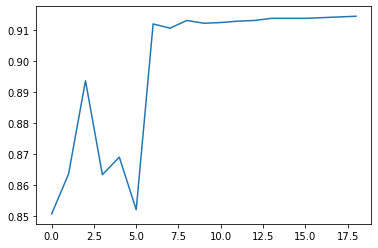

In [0]:
plt.plot(list(range(len(acc_list))), acc_list)
plt.show()

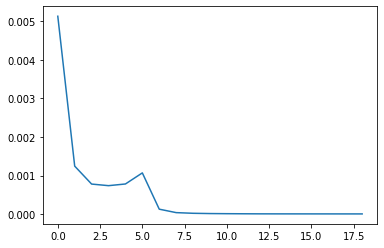

In [0]:
plt.plot(list(range(len(loss_list))), loss_list)
plt.show()

# Тестування моделі

Заради чистоти експерименту завантажимо дані з датасету знову, але вже без їхньої аугментації.

In [0]:
x_train, y_train, _, _ = load_data(os.path.join(root_path, 'train.pickle'))
x_valid, y_valid, _, _ = load_data(os.path.join(root_path, 'valid.pickle'))

# Обов'язкова нормалізаця даних
x_train = transpose_and_normalization(x_train)
x_valid = transpose_and_normalization(x_valid)

def eval_training(model, x_data, y_data):
    model.eval()

    DATA_SIZE = len(x_data)

    test_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for i in range(0, DATA_SIZE, BATCH_SIZE):

            inputs = x_data[i: i + BATCH_SIZE]
            labels = y_data[i: i + BATCH_SIZE]
            
            inputs = torch.from_numpy(inputs)
            labels = torch.from_numpy(labels).long()

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum()
    return 100 * float(correct) / DATA_SIZE

acc_train = eval_training(model, x_train, y_train)
print("Train dataset accuracy: {:.2f}%".format(acc_train))

acc_train = eval_training(model, x_valid, y_valid)
print("Validation dataset accuracy: {:.2f}%".format(acc_train))


Train dataset accuracy: 100.00%
Validation dataset accuracy: 91.45%


Перевіримо швидкість роботи моделі

In [0]:
from datetime import datetime

N = 1000

model_cpu = model.cpu()
inputs = torch.from_numpy(x_train[:16])
t1 = datetime.now()
for i in range(N):
    model_cpu(inputs)
t2 = datetime.now()

print("Work time in cpu + batch_size 16 {}".format((t2 - t1) / N / 16))

model_cpu = model.cpu()
inputs = torch.from_numpy(x_train[:1])
t1 = datetime.now()
for i in range(N):
    model_cpu(inputs)
t2 = datetime.now()

print("Work time in cpu + batch_size 1  {}".format((t2 - t1) / N))

Work time in cpu + batch_size 16 0:00:00.000333
Work time in cpu + batch_size 1  0:00:00.000717


In [0]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total numper of parameters: {}".format(pytorch_total_params))


Total numper of parameters: 1856939


# Перевірка точності моделі на перевернутих зображеннях

In [0]:
import cv2

x_valid, y_valid, _, _ = load_data(os.path.join(root_path, 'valid.pickle'))

shuffle = np.arange(len(y_valid))
np.random.shuffle(shuffle)

x_valid = x_valid[shuffle]
y_valid = y_valid[shuffle]


angels = np.linspace(-180, 180, 21)
h = 32
w = 32
model = model.cuda()
res = []
for an in angels:
    M = cv2.getRotationMatrix2D((h//2, w//2), an, 1.0)
    rotate_valid = []
    for v in x_valid:
        r = cv2.warpAffine(v, M, (h, w))
        rotate_valid.append(r)
    rotate_valid = np.array(rotate_valid).astype(np.float32)
    rotate_valid = transpose_and_normalization(rotate_valid)
    acc = eval_training(model, rotate_valid, y_valid)
    print("angel: {:.2f} acc: {:.2f}%".format(an, acc))
    res.append(acc)

angel: -180.00 acc: 27.82%
angel: -162.00 acc: 22.09%
angel: -144.00 acc: 15.03%
angel: -126.00 acc: 14.76%
angel: -108.00 acc: 15.19%
angel: -90.00 acc: 17.41%
angel: -72.00 acc: 15.94%
angel: -54.00 acc: 12.70%
angel: -36.00 acc: 25.92%
angel: -18.00 acc: 75.90%
angel: 0.00 acc: 91.45%
angel: 18.00 acc: 80.52%
angel: 36.00 acc: 26.71%
angel: 54.00 acc: 14.42%
angel: 72.00 acc: 14.15%
angel: 90.00 acc: 13.76%
angel: 108.00 acc: 15.71%
angel: 126.00 acc: 12.52%
angel: 144.00 acc: 12.47%
angel: 162.00 acc: 21.59%
angel: 180.00 acc: 27.82%


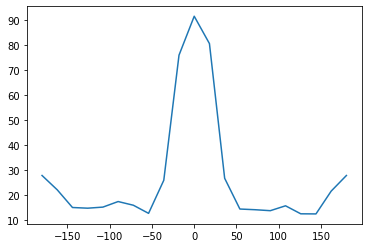

In [0]:
plt.plot(angels, res)
plt.show()

In [0]:
import cv2

x_valid, y_valid, _, _ = load_data(os.path.join(root_path, 'valid.pickle'))

shuffle = np.arange(len(y_valid))
np.random.shuffle(shuffle)

x_valid = x_valid[shuffle]
y_valid = y_valid[shuffle]

model = model.cuda()
gray_valid = []
for v in x_valid:
    img_gray = cv2.cvtColor(v, cv2.COLOR_BGR2GRAY)
    img_gray = np.stack([img_gray, img_gray, img_gray], axis=2)
    gray_valid.append(img_gray)
gray_valid = np.array(gray_valid).astype(np.float32)
gray_valid = transpose_and_normalization(gray_valid)
acc = eval_training(model, gray_valid, y_valid)
print("Gray Image acc: {:.2f}%".format(acc))

Gray Image acc: 84.06%


Отже, було створено та навчено модель для розпізновання знаків 
дорожнього руху. При розробці було зроблено акцент саме на зменшення розміру та швидкість нейронної мережі, тому результат точності лише 91%, при цьому швидкість 0.000660 секунди.

Також було проведено експерименти з форматуванням вхідних даних. Зокрема було продемонстровано, що навчена модель не є стійкою до поворотів картинки. Також було досліджено реакцію картинки на зміну кольору на сірий. У цьому випадку модель показала себе з кращого боку, видавши результат, що лише на ~10% гірший за результат при кольорових зображеннях.